In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.constants as c
import astropy.units as u
import sys
sys.path.pop(1)
sys.path.insert(0,'../')
from matplotlib.colors import LogNorm
import cPickle as pickle

In [2]:
import pyathena as pa

In [3]:
basedir='/Users/ckim/Research/TIGRESS/'
simid='n2e-4_v1414'

## Unit system

The unit system we choose for this simulation is
* [length] = pc
* [velocity] = km/s
* [density] = 1.4271*m_h/cm^3

In [4]:
# You can retrive the unit system with pa.set_units function.
# To make unit conversion easier, I use astropy's unit and constant.
# You may need to install astropy to use it
# please visit http://www.astropy.org/

unit=pa.set_units(muH=1.4271)
print unit['density'].cgs/1.4271/c.m_p.cgs,unit['velocity'],unit['length']

# other units can be easily obtained
print unit['mass'],unit['time'],unit['magnetic_field']


1.0 1 / cm3 1.0 km / s 1.0 pc
0.0352682242985 solMass 0.977792221673 Myr 0.547685223955 uG


## Read Full data cube

Original data cube is stored in "vtk" files. For the MPI simulations, Athena dumps the same number of vtk files with the number of proccessors. Each vtk file has data for all physical variables for a part of the simulation "domain" (it is called "grid"). I wrote a reader to read each grid, get data from it, and merge into a big data array for full domain.

In [5]:
import pyathena as pa

tidx=300
vtkfname='%s%s/id0/%s.%04d.vtk' % (basedir,simid,simid,tidx)

# read in domain information
ds=pa.AthenaDataSet(vtkfname)

In [6]:
# name of original data fields we stored from the simulation
ds.field_list

['density',
 'magnetic_field',
 'pressure',
 'velocity',
 'gravitational_potential']

In [7]:
# It also has predefined data fields can be calculated from the original data.
ds.derived_field_list

['velocity1',
 'velocity2',
 'velocity3',
 'velocity_magnitude',
 'kinetic_energy1',
 'kinetic_energy2',
 'kinetic_energy3',
 'momentum1',
 'momentum2',
 'momentum3',
 'reynold_stress',
 'reynold_stress1',
 'reynold_stress2',
 'reynold_stress3',
 'sound_speed',
 'temperature',
 'T1',
 'potential_energy',
 'gravity_stress',
 'gravity_stress1',
 'gravity_stress2',
 'gravity_stress3',
 'number_density',
 'magnetic_field1',
 'magnetic_field2',
 'magnetic_field3',
 'magnetic_energy1',
 'magnetic_energy2',
 'magnetic_energy3',
 'magnetic_pressure',
 'plasma_beta',
 'alfven_velocity1',
 'alfven_velocity2',
 'alfven_velocity3',
 'magnetic_stress',
 'magnetic_stress1',
 'magnetic_stress2',
 'magnetic_stress3']

In [8]:
# full domain information 
ds.domain

{'Lx': array([ 1024.,  1024.,  7168.], dtype=float32),
 'Nx': array([ 64,  64, 448]),
 'center': array([ 0.,  0.,  0.], dtype=float32),
 'dx': array([ 16.,  16.,  16.], dtype=float32),
 'field_map': {'density': {'dsize': 524288,
   'dtype': 'f',
   'ndata': 131072,
   'nvar': 1,
   'offset': 251,
   'read_table': True},
  'gravitational_potential': {'dsize': 524288,
   'dtype': 'f',
   'ndata': 131072,
   'nvar': 1,
   'offset': 4194699,
   'read_table': True},
  'magnetic_field': {'dsize': 1572864,
   'dtype': 'f',
   'ndata': 393216,
   'nvar': 3,
   'offset': 2621804,
   'read_table': False},
  'pressure': {'dsize': 524288,
   'dtype': 'f',
   'ndata': 131072,
   'nvar': 1,
   'offset': 2097471,
   'read_table': True},
  'velocity': {'dsize': 1572864,
   'dtype': 'f',
   'ndata': 393216,
   'nvar': 3,
   'offset': 524583,
   'read_table': False}},
 'left_edge': array([ -512.,  -512., -3584.], dtype=float32),
 'ndim': 3,
 'nscal': 0,
 'right_edge': array([  512.,   512.,  3584.], dty

In [9]:
# information of grid #0
ds.grids[0]

{'Nx': array([64, 64, 32]),
 'data': {},
 'data_offset': 251,
 'dx': array([ 16.,  16.,  16.]),
 'filename': '/Users/ckim/Research/TIGRESS/n2e-4_v1414/id0/n2e-4_v1414.0300.vtk',
 'is': array([0, 0, 0]),
 'left_edge': array([ -512.,  -512., -3584.]),
 'ncells': 131072,
 'prim_var_type': True,
 'read_field': 'density',
 'read_type': 'scalar',
 'right_edge': array([  512.,   512., -3072.]),
 'time': 300.0018,
 'vtk_version': '3.0'}

In [10]:
# yet, we didn't read data. 
# let's read each data field in a full domain

# this can be original data fields
d=ds.read_all_data('density')
print d.shape
# note that it adopts C-like indexing, k (z-index) comes first and i (x-index) comes last
# vector field has 3 component
v=ds.read_all_data('velocity')
print v.shape
vx=v[:,:,:,0]
vy=v[:,:,:,1]
vz=v[:,:,:,2]

# or you can use derived fields
v1=ds.read_all_data('velocity1')
v2=ds.read_all_data('velocity2')
v3=ds.read_all_data('velocity3')

print vx.shape,v1.shape,(vx == v1).all()

(448, 64, 64)
(448, 64, 64, 3)
(448, 64, 64) (448, 64, 64) True


In [11]:
# calculate sound speed
P=ds.read_all_data('pressure')
cs=np.sqrt(P/d)

In [12]:
# calculation of temperature needs additional information about mean molecular weight I adopt
coolftn=pa.coolftn()
temp=coolftn.get_temp(P/d)

In [13]:
xmin=ds.domain['left_edge']
xmax=ds.domain['right_edge']
dx=ds.domain['dx']
Nx=ds.domain['Nx']

# set cell centered coordinates
x=np.arange(xmin[0],xmax[0],dx[0])+0.5*dx[0]
y=np.arange(xmin[1],xmax[1],dx[1])+0.5*dx[1]
z=np.arange(xmin[2],xmax[2],dx[2])+0.5*dx[2]

# calculate background velocity vy_0=-q*Omega*x
vy0=-28.e-3*x

# substract it to get a perturbed velocity in y-dir.
dv2=v2-np.tile(vy0.reshape(1,1,Nx[0]),(Nx[2],Nx[1],1))


In [14]:
#find index for maximum density
imax=np.argmax(d)
#unravel the index to 3d-form
imax=np.unravel_index(imax,d.shape)[::-1]
print imax

(35, 47, 254)


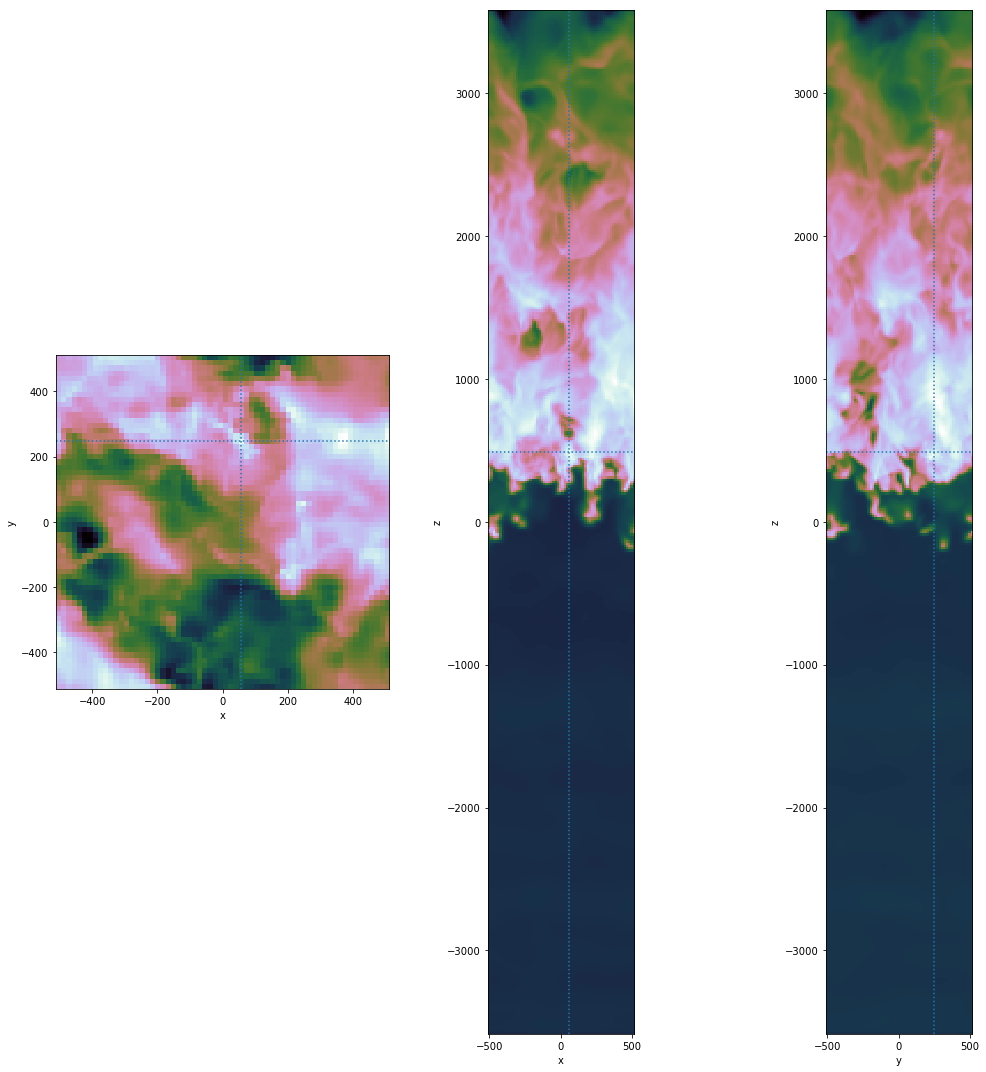

In [15]:
# density projection at density maximum
# Note that the z-axis comes first and x-axis comes last (C-style array indexing)
dproj=[]
x_coord=['x','x','y']
i_coord=[0,0,1]
y_coord=['y','z','z']
j_coord=[1,2,2]
max_pos=[x[imax[0]],y[imax[1]],z[imax[2]]]

fig=plt.figure(figsize=(15,15))

for i in range(3):
    dproj.append(d.mean(axis=i))
    
for i in range(3):
    plt.subplot(1,3,i+1)
    im=plt.imshow(dproj[i],origin='lower',norm=LogNorm())
    im.set_extent([xmin[i_coord[i]],xmax[i_coord[i]],xmin[j_coord[i]],xmax[j_coord[i]]])
    im.set_cmap(plt.cm.cubehelix)
    plt.axvline(max_pos[i_coord[i]],ls=':')
    plt.axhline(max_pos[j_coord[i]],ls=':')
    plt.xlabel(x_coord[i])
    plt.ylabel(y_coord[i])
plt.tight_layout()

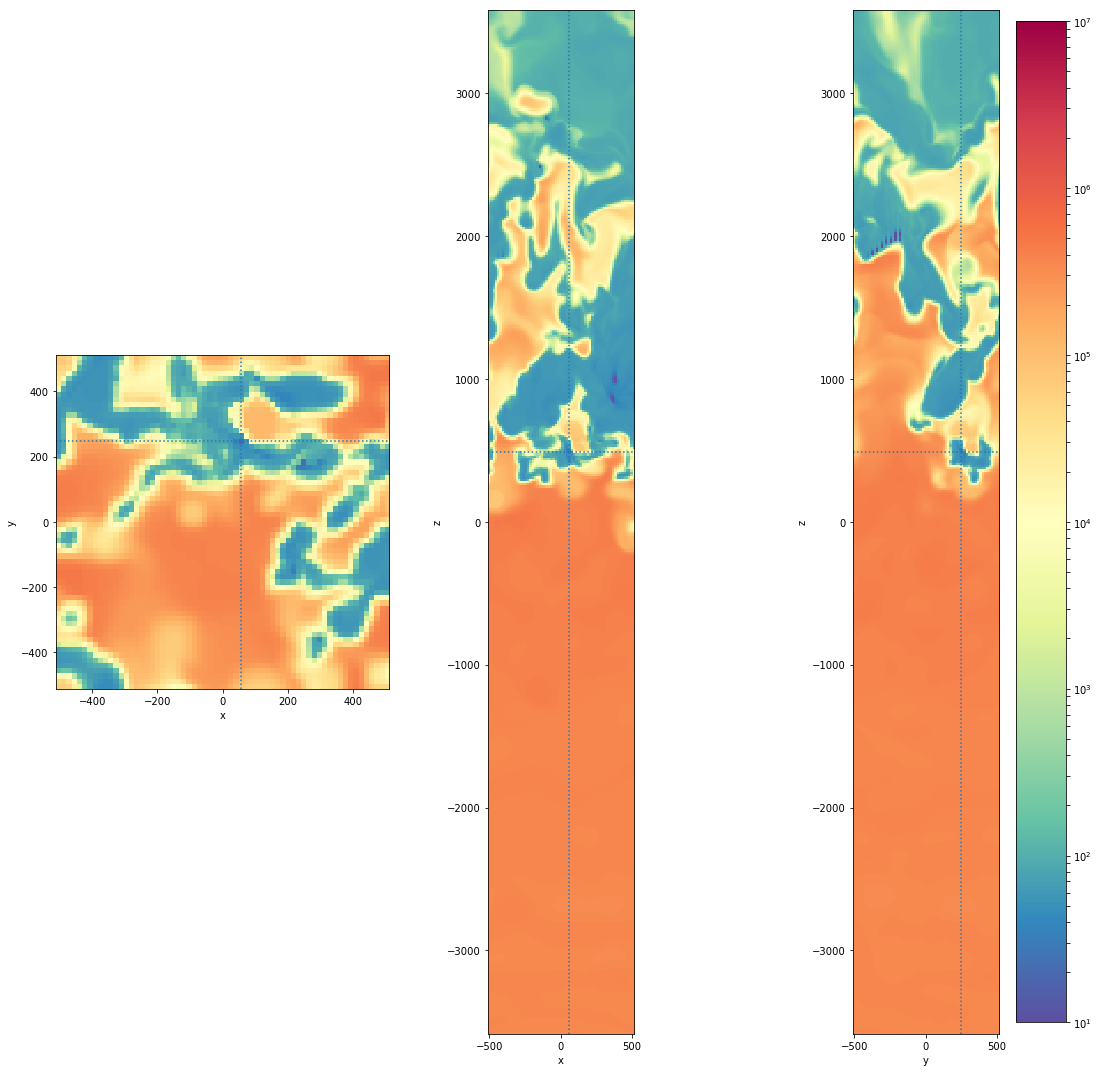

In [16]:
# tempersure projection with density weights
# Note that the z-axis comes first and x-axis comes last (C-style array indexing)
Tslc=[]
x_coord=['x','x','y']
i_coord=[0,0,1]
y_coord=['y','z','z']
j_coord=[1,2,2]
max_pos=[x[imax[0]],y[imax[1]],z[imax[2]]]

fig=plt.figure(figsize=(15,15))

Tslc.append(temp[imax[2],:,:])
Tslc.append(temp[:,imax[1],:])
Tslc.append(temp[:,:,imax[0]])
    
for i in range(3):
    plt.subplot(1,3,i+1)
    im=plt.imshow(Tslc[i],origin='lower',norm=LogNorm())
    im.set_extent([xmin[i_coord[i]],xmax[i_coord[i]],xmin[j_coord[i]],xmax[j_coord[i]]])
    im.set_cmap(plt.cm.Spectral_r)
    im.set_clim(10,1.e7)
    plt.axvline(max_pos[i_coord[i]],ls=':')
    plt.axhline(max_pos[j_coord[i]],ls=':')
    plt.xlabel(x_coord[i])
    plt.ylabel(y_coord[i])
plt.tight_layout()
plt.colorbar(im)

# Star Particles

In [17]:
# we have star particles, representing star clusters and runaway OB stars
# the star particle information is stored at /data-directory/id0/
# read_starvtk return particle information in "pandas.DataFrame", which provides a good data handler
# please visit http://pandas.pydata.org/ 

starfname=vtkfname.replace('id0','starpar').replace('vtk','starpar.vtk')
sp=pa.read_starvtk(starfname)


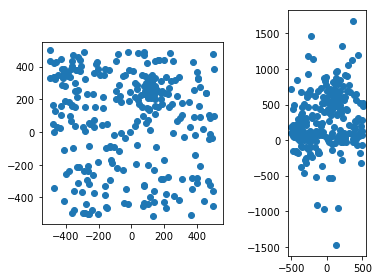

In [18]:
# Let's plot star particles
plt.subplot(121,aspect='equal')
plt.plot(sp['x1'],sp['x2'],'o')
plt.subplot(122,aspect='equal')
plt.plot(sp['x1'],sp['x3'],'o')
plt.tight_layout()

0.977792221673
289 254
248 6


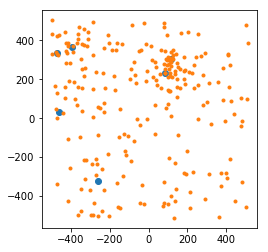

In [19]:
# select young star particles (age < 40Myr)
# first, we need to convert age in Myr
Myr=unit['time'].to('Myr').value
print Myr
young_sp=sp[sp['age']*Myr < 40.]
print len(sp),len(young_sp)

# second, separate clusters (mass != 0) and runaways (mass == 0)
# mass of runaway OB stars was set to zero
runaway=young_sp[young_sp['mass'] == 0]
cluster=young_sp[young_sp['mass'] != 0]
plt.subplot(111,aspect='equal')
plt.plot(cluster['x1'],cluster['x2'],'o')
plt.plot(runaway['x1'],runaway['x2'],'.')
print len(runaway),len(cluster)

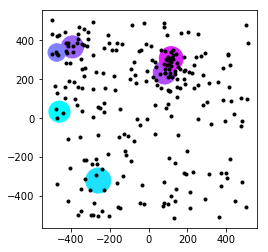

In [20]:
# using scatter plot, we can set size and color cluster particles based on their mass and age, respectively.
# let's convert mass and age in Msun and Myr, respectively.
Msun=unit['mass'].to('Msun').value
mass=cluster['mass']*Msun
age=cluster['age']*Myr
ax=plt.subplot(111,aspect='equal')
ax.scatter(cluster['x1'],cluster['x2'],marker='o',s=mass/100.,c=age,
           vmax=40,vmin=0,cmap=plt.cm.cool_r)
plt.plot(runaway['x1'],runaway['x2'],'.k')


# Surface density map with star particles 
Let's calculate surface density mape integrated along the z-axis:
$$\Sigma \equiv \int \rho dz $$

In [21]:
dz=z[1]-z[0]
surf=d.sum(axis=0)*unit['density']*dz*unit['length']
print surf.shape
print surf.unit
print surf.mean()

(64, 64)
solMass / pc2
10.6699991226 solMass / pc2


In [22]:
#it's always good idea to modulize your code
def mass_norm(mass):
    '''
    Mass normlization function to determine symbol size
    This should be called both in sp_plot and sp_legend for the consistent result
    '''
    return np.sqrt(mass)
    #return mass/50.

def sp_plot(ax,sp,plot_runaway=True):
    '''
    This is comment for the function.
    This will be printed when you call your function in help.
    You may want to write usage or examples.
    '''
    import pyathena as pa
    unit=pa.set_units(muH=1.4271)
    Msun=unit['mass'].to('Msun').value
    Myr=unit['time'].to('Myr').value
    
    young_sp=sp[sp['age']*Myr < 40.]
    runaway=young_sp[young_sp['mass'] == 0]
    cluster=young_sp[young_sp['mass'] != 0]
    
    mass=cluster['mass']*Msun
    age=cluster['age']*Myr
    
    cl=ax.scatter(cluster['x1'],cluster['x2'],marker='o',s=mass_norm(mass),c=age,
               vmax=40,vmin=0,cmap=plt.cm.cool_r)
    if(plot_runaway): ax.scatter(runaway['x1'],runaway['x2'],marker='.',color='k')
    
    return cl

def sp_legend(ax,ref_mass=[1.e3,1.e4,1.e5]):
    ext=ax.images[0].get_extent()

    #plot particle references outside of the domain of interest
    s=[]
    label=[]
    for mass in ref_mass:
        s.append(ax.scatter(ext[1]*2,ext[3]*2,s=mass_norm(mass),color='k',alpha=.5))
        label.append(r'$10^%d M_\odot$' % np.log10(mass))
    ax.set_xlim(ext[0],ext[1])
    ax.set_ylim(ext[2],ext[3])
    legend=ax.legend(s,label,scatterpoints=1,loc=2,ncol=3,fontsize='small',bbox_to_anchor=(0.0, 1.1), frameon=False)
    
    return legend


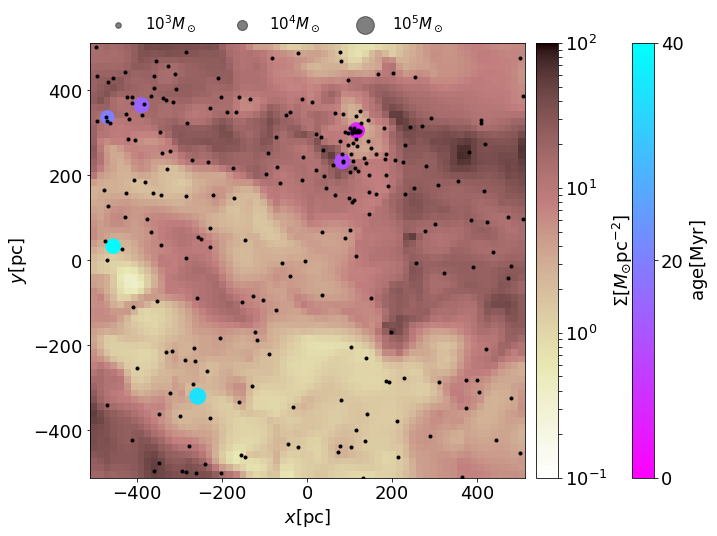

In [23]:
import matplotlib as mpl
# let's combine surface density map with star particles.
fig=plt.figure(figsize=(12,8))
plt.rcParams['font.size']=18

ax=fig.add_subplot(111)
im=ax.imshow(surf.value,norm=LogNorm(),origin='lower')
im.set_extent([xmin[0],xmax[0],xmin[1],xmax[1]])

cl=sp_plot(ax,sp)
leg=sp_legend(ax)
im.set_clim(1.e-1,1.e2)
im.set_cmap(plt.cm.pink_r)
ax.set_xlabel(r'$x [{\rm pc}]$')
ax.set_ylabel(r'$y [{\rm pc}]$')

# Here's one example to draw colorbars
cax2,kw=mpl.colorbar.make_axes(ax,fraction=0.1,pad=0.06)
cbar2 = mpl.colorbar.ColorbarBase(cax2, ticks=[0,20,40],
                                  cmap=plt.cm.cool_r, norm=mpl.colors.Normalize(vmin=0,vmax=40),orientation='vertical')
cbar2.set_label(r'${\rm age [Myr]}$')

cax,kw=mpl.colorbar.make_axes(ax,fraction=0.1,pad=0.02)
cbar=plt.colorbar(im,cax=cax)
cbar.set_label(r'$\Sigma [M_{\odot} {\rm pc}^{-2}]$')

# You can save figure by commenting out the following command
fig.savefig('surfmap.png',bbox_inches='tight')

(-1000, 3000)

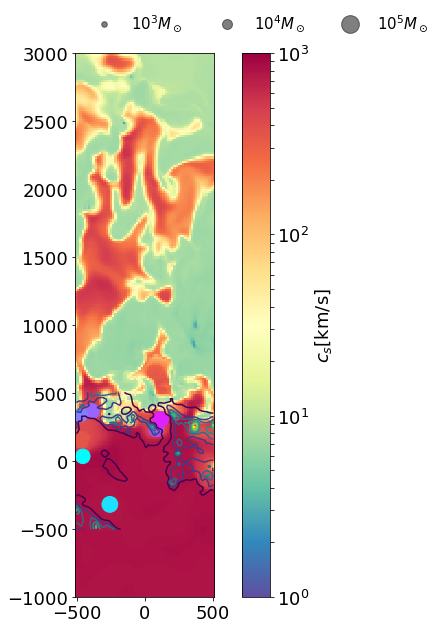

In [24]:
fig=plt.figure(figsize=(10,10))
ax=plt.subplot(111)
i=1
im=plt.imshow(cs[:,imax[1],:],origin='lower',norm=LogNorm(vmin=1,vmax=1.e3),interpolation='nearest')
im.set_extent([xmin[0],xmax[0],xmin[2],xmax[2]])
im.set_cmap(plt.cm.Spectral_r)
cb=plt.colorbar(im)
cb.set_label(r'$c_s [{\rm km/s}]$')
X, Y = np.meshgrid(x,y)
ct=plt.contour(X,Y,d.mean(axis=0))

#you can reuse the plotting functions defined before!
sp_plot(ax,sp,plot_runaway=False)
sp_legend(ax)

plt.xlim(im.get_extent()[:2])
plt.ylim(-1000,3000)